In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from generation.training.utils import set_seed

set_seed()

Set seed 42


In [2]:
# !pip install -e ../..

### Config

In [3]:
config = {
    "lr": 1e-5,
    "epochs_num": 3000,
    "batch_size": 64,
    "log_each": 1,
    "save_each": 2,
    "device": "cuda:2",
    "x_dim": 1024,
    "z_dim": 8,
    "disc_coef": 5,
    "lambda": 5
}

### Data

In [4]:
from generation.dataset.signals_dataset import SignalsDataset
            
dataset = SignalsDataset(0, signal_size=config['x_dim'])

/datadrive/pafakanov/hse/hep_generative_models/generation/dataset/signals_dataset.py:54: RuntimeWarning: invalid value encountered in true_divide
  data = (data - min_values[:, None]) / (max_values - min_values)[:, None]


Signal size: (1024,)


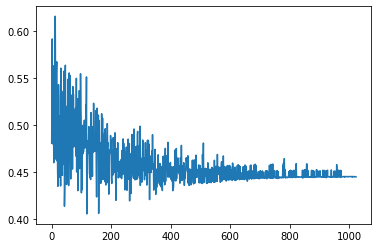

In [5]:
signal = dataset[900].numpy()
print("Signal size:", signal.shape)
plt.plot(signal)
plt.show()

### Models

In [6]:
from generation.nets.shapes_1d import Generator, Discriminator

In [7]:
discriminator = Discriminator(config)
test_tensor = dataset[0].unsqueeze(0)
discriminator(test_tensor, debug=True)
generator = Generator(config)
test_z = torch.rand(1, config['z_dim'])
output = generator(test_z, debug=True)
assert(output.shape == test_tensor.shape)

torch.Size([1, 1, 1024])
torch.Size([1, 8, 1024])
torch.Size([1, 8, 340])
torch.Size([1, 32, 340])
torch.Size([1, 32, 112])
torch.Size([1, 8, 112])
torch.Size([1, 8, 36])
torch.Size([1, 288])
torch.Size([1, 1])
torch.Size([1, 1024])
torch.Size([1, 1, 1024])
torch.Size([1, 8, 1024])
torch.Size([1, 32, 1024])
torch.Size([1, 16, 1024])
torch.Size([1, 8, 1024])
torch.Size([1, 1, 1024])


### Training

In [8]:
from generation.training.wgan_trainer import WganTrainer

g_optimizer = torch.optim.Adam(generator.parameters(), lr=config['lr'])
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['lr'])

trainer = WganTrainer(generator, discriminator, g_optimizer, \
                      d_optimizer, config)

In [ ]:
trainer.run_train(dataset)

wandb: Currently logged in as: whitera2bit (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200926_204337-1ner3t5a
wandb: Syncing run true-deluge-225


In [82]:
from torch.autograd import Variable

z = Variable(torch.rand(config['batch_size'], config['z_dim']))
z = z.to(config['device'])

generated = generator(z)
generated_noises = np.array([sample.cpu().data.numpy() for sample in generated])
generated_noises = dataset.scaler.inverse_transform(samples)

origin_noises = dataset.noises
origin_noises = dataset.scaler.inverse_transform(origin_noises)

In [97]:
import os

from generation.config import CHECKPOINTS_DIR

def get_checkpoint_path(model, config):
    checkpoint_name = "discriminator"
    for key, value in config.items():
        checkpoint_name += f"_{key}_{value}"
    checkpoint_path = os.path.join(CHECKPOINTS_DIR, \
                                   f"{checkpoint_name}.pt")
    return checkpoint_path

save_path = get_checkpoint_path(discriminator, config)
if not os.path.exists(CHECKPOINTS_DIR):
    os.makedirs(CHECKPOINTS_DIR)
torch.save(discriminator.state_dict(), save_path)



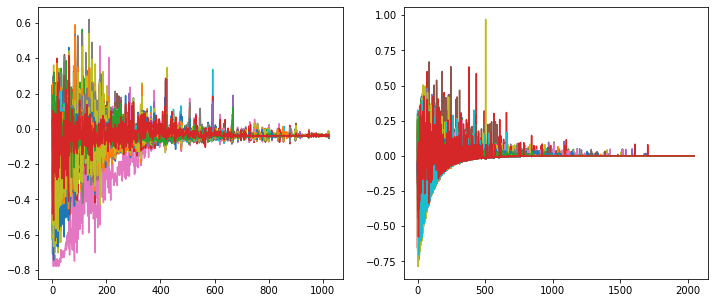

In [83]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, noise in enumerate(generated_noises):
    idx = np.random.choice(range(len(dataset)))
    ax[0].plot(generated__noises[i])
    ax[1].plot(origin_noises[idx])

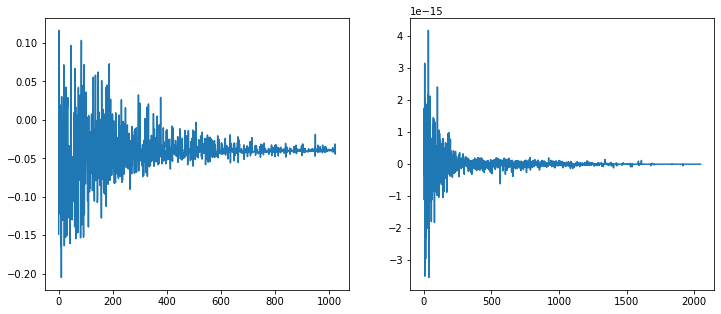

In [84]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(np.mean(generated_noises, axis=0))
ax[1].plot(np.mean(origin_noises, axis=0))
plt.show()

In [85]:
generated_mean_noise = np.mean(generated_noises, axis=0)
generated_noises = generated_noises - generated_mean_noise

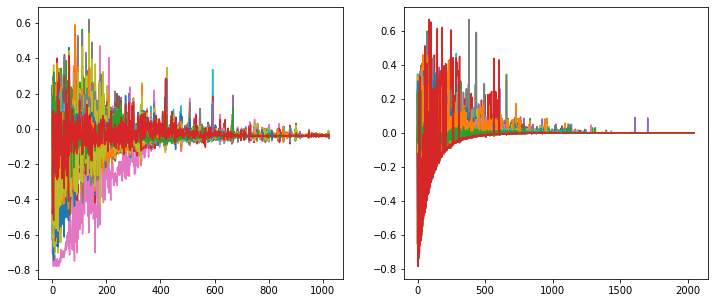

In [86]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, noise in enumerate(generated_noises):
    idx = np.random.choice(range(len(dataset)))
    ax[0].plot(generated__noises[i])
    ax[1].plot(origin_noises[idx])